In [ ]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#read data
df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')
df.info()
#seed for "random state" when training models
seed=42

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
#quick overview of data
df.head()


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Unique Sentiment Labels: [4 0]


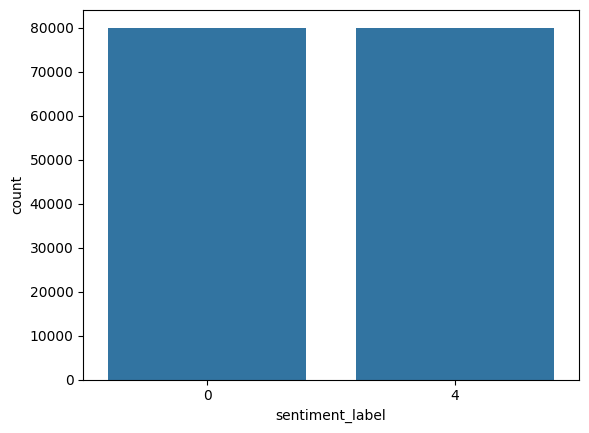

In [ ]:
#Visualize the amount of 0s and 4s
sns.countplot(x='sentiment_label', data=df)
#and checking that there are no other unique values
unique_sentiments = df['sentiment_label'].unique()
print("Unique Sentiment Labels:", unique_sentiments)

In [ ]:

def preprocess_text(sen):

    #remove any urls
    sentence = re.sub(r'http?://\S+|www\.\S+', '', sen, flags=re.MULTILINE)
    #remove non-alphabetical characters
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)

    #tokenize
    words = word_tokenize(sentence)

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    sentence = [lemmatizer.lemmatize(word) for word in words if word.lower() not in set(stopwords.words('english'))]

    return sentence


In [ ]:
X = []
tweets = list(df["tweet_text"])
for tweet in tweets:
    X.append(preprocess_text(tweet))


In [ ]:
#sentiment values to y
y = df["sentiment_label"]

y = np.array(list(map(lambda x: 1 if x>0 else 0, y)))
print (y)

[1 1 0 ... 1 1 1]


In [ ]:
#divide into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [ ]:
#convert the data back to strings
X_train_strings = [' '.join(words) for words in X_train]
X_test_strings = [' '.join(words) for words in X_test]

#tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_strings)

#data to sequence to train RNN model
X_train_sequences = tokenizer.texts_to_sequences(X_train_strings)
X_test_sequences = tokenizer.texts_to_sequences(X_test_strings)

In [ ]:
#print sequence for debugging
print (X_train_sequences[1])#TA BORT

[3415, 53, 19, 40, 637, 6, 1020, 6, 120, 425, 1317, 739, 192, 765, 1161, 240, 10, 240, 10, 15, 14]


In [ ]:
#print sequence as test for debugging
original_text = tokenizer.sequences_to_texts([X_train_sequences[1]])[0]
print(original_text)

oooo would really feel beat quot double quot n nite imma save th jus kno gt u gt u back lol


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

#calculate how much padding needed
maxlen = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_test_sequences))

#pad sequences
X_train_sequences = pad_sequences(X_train_sequences, padding="post", maxlen=maxlen)
X_test_sequences = pad_sequences(X_test_sequences, padding="post", maxlen=maxlen)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 16, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))  # 2 output classes for positive, negative, neutral

#create model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train model
model.fit(X_train_sequences, y_train, epochs=4, validation_data=(X_test_sequences, y_test))

#evaluate model
loss, accuracy_nn = model.evaluate(X_test_sequences, y_test)
print(f"Test Accuracy: {accuracy_nn * 100:.2f}%")

Epoch 1/4
4000/4000 [==============================] - 135s 33ms/step - loss: 0.5243 - accuracy: 0.7377 - val_loss: 0.5005 - val_accuracy: 0.7614
Epoch 2/4
4000/4000 [==============================] - 133s 33ms/step - loss: 0.4694 - accuracy: 0.7749 - val_loss: 0.4939 - val_accuracy: 0.7605
Epoch 3/4
4000/4000 [==============================] - 132s 33ms/step - loss: 0.4477 - accuracy: 0.7852 - val_loss: 0.4938 - val_accuracy: 0.7617
Epoch 4/4
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5132 - accuracy: 0.7587
Test Accuracy: 75.87%


1000/1000 [==============================] - 6s 5ms/step


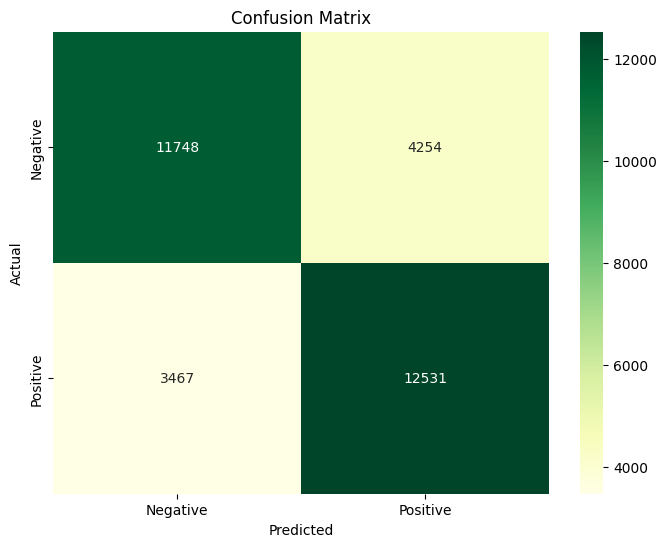

In [ ]:

#predictions
predictions = model.predict(X_test_sequences)
y_pred_RNN = np.argmax(predictions, axis=1)

# create confusion matrix for RNN model
conf_matrix_nn = confusion_matrix(y_test, y_pred_RNN)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='YlGn', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#data to matrix
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train_strings)
X_test_bow = vectorizer.transform(X_test_strings)

#Train NB model
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

#preductions
y_pred_NB = nb_model.predict(X_test_bow)

#evaluate model
accuracy_nb = accuracy_score(y_test, y_pred_NB)
#classification_rep = classification_report(y_test, y_pred_NB)
#print accuracy
print(f"Test Accuracy: {accuracy_nb * 100:.2f}%")


Test Accuracy: 75.29%


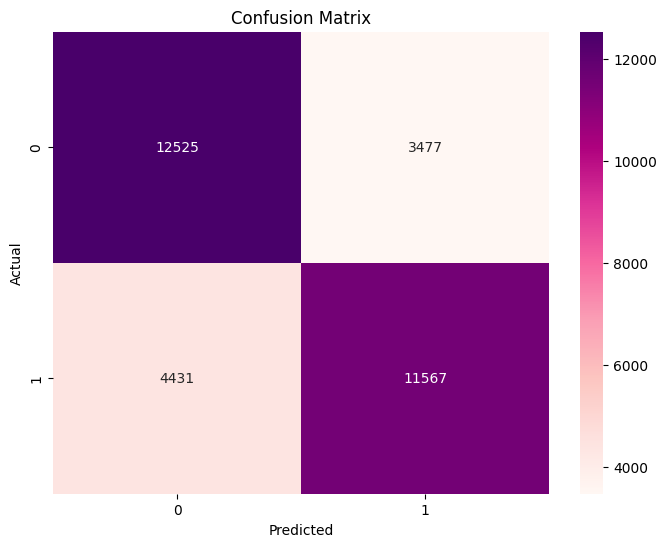

In [ ]:
#create confusion matrix for nb
conf_matrix_nb = confusion_matrix(y_test, y_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='RdPu', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

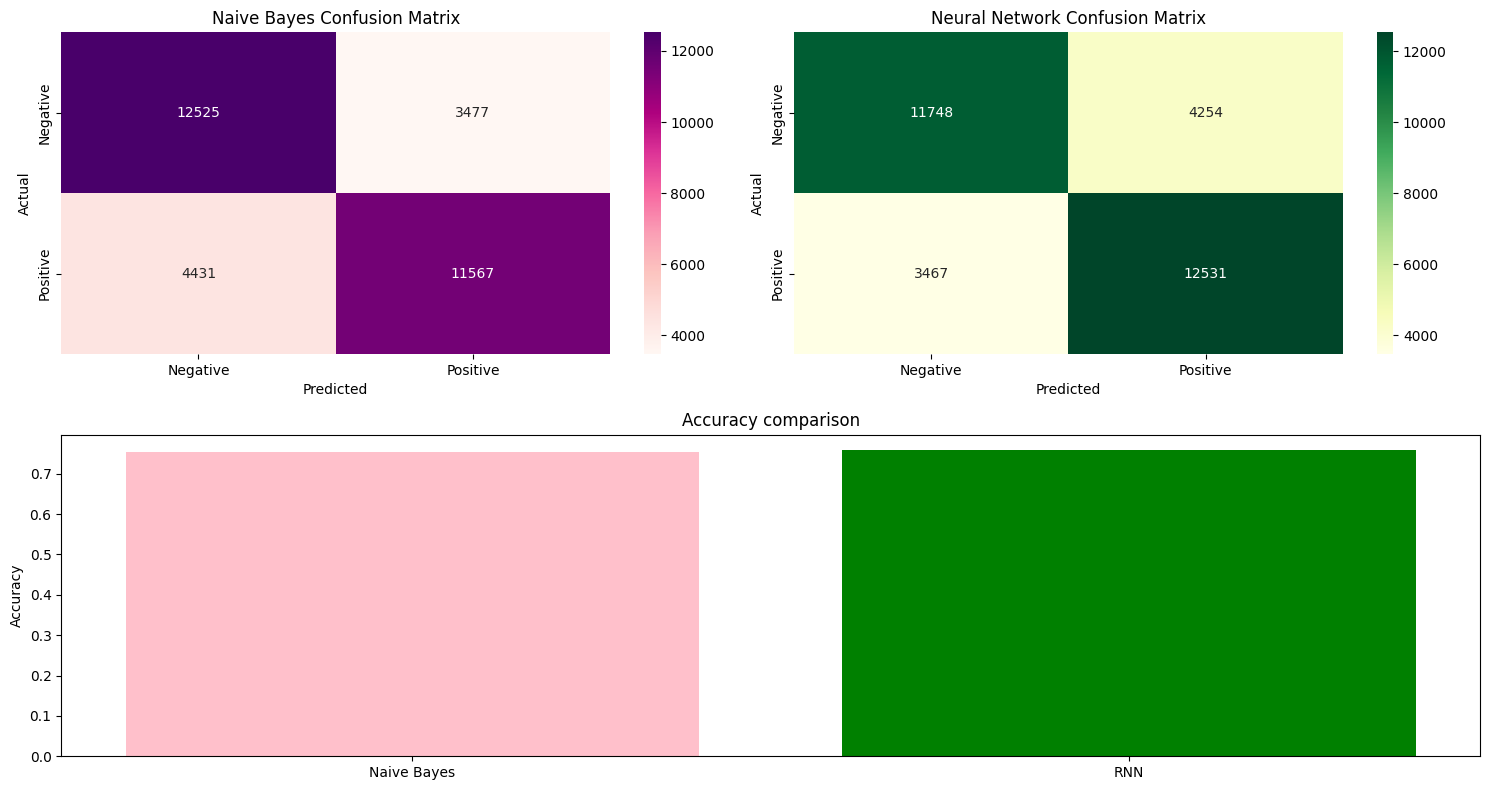

NB Test Accuracy: 75.29%
RNN Test Accuracy: 75.87%


In [ ]:
#create confuison matrixes and plot to compare the 2 models

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='RdPu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='YlGn', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')

plt.subplot(2, 1, 2)
methods = ['Naive Bayes', 'RNN']
accuracies = [accuracy_nb, accuracy_nn]
plt.bar(methods, accuracies, color=['pink', 'green'])
plt.ylabel('Accuracy')
plt.title('Accuracy comparison')

plt.tight_layout()
plt.show()
print(f"NB Test Accuracy: {accuracy_nb * 100:.2f}%")
print(f"RNN Test Accuracy: {accuracy_nn * 100:.2f}%")